<a href="https://colab.research.google.com/github/ryanreilly/phase_5_capstone/blob/main/VGG16_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#This cell is connecting to my google drive and loading the train, validation and test folders. 
from google.colab import drive
!unzip drive/MyDrive/train.zip
!unzip drive/MyDrive/dev.zip
!unzip drive/MyDrive/test.zip

In [ ]:
#This cell is showing me what GPU Google is giving me.  
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [2]:
#Create variables for each directory
train_dir = 'train'
validation_dir = 'dev'
test_dir = 'test'

In [20]:
#Import Libraries

#For manipulating and visualizing images
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow
import keras
import itertools
#To load an image using Keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers, models, applications
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, load_model

#To plot confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report 

#to track how long the models run
import datetime

#For dividing the images into correct folders
import shutil
import os

#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

VGG16 Transfer Learning Model


In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
            
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#Create the tarin and validation generators
train_generator_vgg2 = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

validation_generator_vgg2 = validation_datagen.flow_from_directory(validation_dir, 
                                                              target_size=(224, 224), 
                                                              batch_size=32, 
                                                              class_mode='categorical',
                                                              shuffle=False)

Build the model

In [ ]:
vggmodel2 = VGG16(weights='imagenet',
                  input_shape= (224,224,3), 
                  include_top=True)

vggmodel2.trainable = False

# Define Model Architecture
X = vggmodel2.layers[-2].output
X = Dropout(0.2)(X)
predictions = Dense(7, activation="softmax")(X)
model_final2 = Model(inputs = vggmodel2.input, outputs = predictions)


for layer in vggmodel2.layers:
    layer.trainable = False


opt = optimizers.Adam(learning_rate=0.00001)
model_final2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("vgg16_2.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)

vgg_2_hist = model_final2.fit_generator(generator= train_generator_vgg2,
                                    #steps_per_epoch= 10, 
                                    epochs= 100, 
                                    validation_data= validation_generator_vgg2, 
                                    validation_steps=1, 
                                    callbacks=[checkpoint])

Epoch 1/100
389/389 [==============================] - 264s 677ms/step - loss: 1.9087 - accuracy: 0.2425 - val_loss: 1.6412 - val_accuracy: 0.0312

Epoch 00001: val_accuracy improved from -inf to 0.03125, saving model to vgg16_2.h5
Epoch 2/100
389/389 [==============================] - 263s 675ms/step - loss: 1.8093 - accuracy: 0.2982 - val_loss: 1.4687 - val_accuracy: 0.4375

Epoch 00002: val_accuracy improved from 0.03125 to 0.43750, saving model to vgg16_2.h5
Epoch 3/100
389/389 [==============================] - 262s 674ms/step - loss: 1.7571 - accuracy: 0.3220 - val_loss: 1.4295 - val_accuracy: 0.5938

Epoch 00003: val_accuracy improved from 0.43750 to 0.59375, saving model to vgg16_2.h5
Epoch 4/100
389/389 [==============================] - 262s 673ms/step - loss: 1.7059 - accuracy: 0.3512 - val_loss: 1.4597 - val_accuracy: 0.5312

Epoch 00004: val_accuracy did not improve from 0.59375
Epoch 5/100
389/389 [==============================] - 263s 675ms/step - loss: 1.6683 - accurac

Plot the accuarcy and loss for training and validation


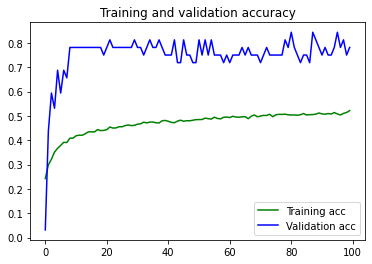

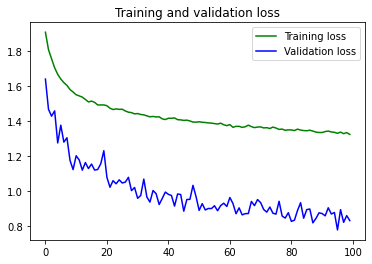

In [ ]:
acc = vgg_2_hist.history['accuracy']
val_acc = vgg_2_hist.history['val_accuracy']
loss = vgg_2_hist.history['loss']
val_loss = vgg_2_hist.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
test_generator_vgg2 = test_datagen.flow_from_directory(test_dir, 
                                                              target_size=(224, 224), 
                                                              batch_size=32, 
                                                              class_mode='categorical',
                                                              shuffle=False)

Found 3147 images belonging to 7 classes.


Load the model. I had to do this because I came back to the model after it ran

In [6]:
best_vgg2_model=load_model('/content/drive/MyDrive/vgg16_2.h5')

In [ ]:
y_pred_best = best_vgg2_model.predict(test_generator_vgg2, batch_size=32)

In [16]:
y_pred_best = np.argmax(y_pred_best, axis=1)

In [17]:
def plot_confusion_mat(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
    else:
      print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
cm_plot_labels = [key for key,value in test_generator_vgg2.class_indices.items()]
cm = confusion_matrix(test_generator_vgg2.classes, y_pred_best)

Confusion matrix, without normalization


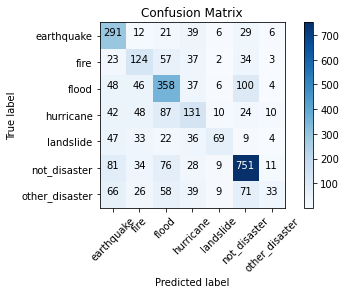

In [21]:
plot_confusion_mat(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [22]:
print(classification_report(test_generator_vgg2.classes, y_pred_best, target_names = [key for key,value in test_generator_vgg2.class_indices.items()]))

                precision    recall  f1-score   support

    earthquake       0.49      0.72      0.58       404
          fire       0.38      0.44      0.41       280
         flood       0.53      0.60      0.56       599
     hurricane       0.38      0.37      0.37       352
     landslide       0.62      0.31      0.42       220
  not_disaster       0.74      0.76      0.75       990
other_disaster       0.46      0.11      0.18       302

      accuracy                           0.56      3147
     macro avg       0.51      0.47      0.47      3147
  weighted avg       0.56      0.56      0.54      3147

